### Team 02 Project A* Algorithm
**Team Members:**

- 박나희 **22200280**
  
- 장석범 **21700625**
  
  
- 에스마우 후마 드지카 엡세 **22347009**

- 
카밀 차즈아드 디나 발  **즈/223470**12


#### Importing Necessary Libraries

In [3]:
# Import the pandas library for data manipulation and computations
import pandas as pd
import numpy as np

# Import the math library for mathematical operations
import math

# Import the heapq library for heap queue operations
import heapq

# Import matplotlib.pyplot for plotting
import matplotlib.pyplot as plt

#### Exploring datasets

In [5]:
# Read the CSV file containing data on Korean airports into a DataFrame
Korean_airports = pd.read_csv('Korean_airports.csv')

# Read the CSV file containing data on Korean airways into a DataFrame
Korean_airways = pd.read_csv('Korean_airways.csv')

In [6]:
#Viewing rows of Korean airports
Korean_airports.head(10)

,Name,Type,IATA,ICAO,Longitude (deg),Latitude (deg)
0,Incheon,International,ICN,RKSI,126.449800,37.446500
1,Jeju,International,CJU,RKPC,126.624120,33.384605
2,Cheongju,International,CJJ,RKTU,127.498900,36.716400
3,Yangyang,International,YNY,RKNY,128.668900,38.061100
4,Pohang,Domestic,KPO,RKTH,129.420500,35.987900
5,Gimhae,International,PUS,RKPK,128.938100,35.179400
6,Gimpo,International,GMP,RKSS,126.993183,37.213614


In [7]:
#Viewing airways dataset
Korean_airways.head()

,Name,Start Longitude (deg),Start Latitude (deg),End Longitude (deg),End Latitude (deg)
0,A582,127.348575,36.838358,127.500925,36.714367
1,A582,127.500925,36.714367,127.819172,36.453422
2,A582,127.819172,36.453422,128.029970,36.279140
3,A582,128.029970,36.279140,128.590770,35.809835
4,A582,128.590770,35.809835,128.774025,35.503350


In [8]:
#Checking airways info
Korean_airways.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   169 non-null    object 
 1   Start Longitude (deg)  169 non-null    float64
 2   Start Latitude (deg)   169 non-null    float64
 3   End Longitude (deg)    169 non-null    float64
 4   End Latitude (deg)     169 non-null    float64
dtypes: float64(4), object(1)
memory usage: 6.7+ KB


In [9]:
#dropping row corresponding to disconnected 2 points to remove from graph
Korean_airways = Korean_airways.drop(11, axis = 0)

In [10]:
# Round to 4 decimal places
Korean_airports['Latitude (deg)'] = Korean_airports['Latitude (deg)'].round(4)
Korean_airports['Longitude (deg)'] = Korean_airports['Longitude (deg)'].round(4)
Korean_airways['Start Latitude (deg)'] = Korean_airways['Start Latitude (deg)'].round(4)
Korean_airways['Start Longitude (deg)'] = Korean_airways['Start Longitude (deg)'].round(4)
Korean_airways['End Latitude (deg)'] = Korean_airways['End Latitude (deg)'].round(4)
Korean_airways['End Longitude (deg)'] = Korean_airways['End Longitude (deg)'].round(4)

#### Graph Representation Using Adjacency List

In [12]:
#Calculating great circle distance using harversine formula
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees).
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Create an adjacency list
adjacency_list = {}

for idx, row in Korean_airways.iterrows():
    start = (row['Start Longitude (deg)'], row['Start Latitude (deg)'])
    end = (row['End Longitude (deg)'], row['End Latitude (deg)'])
    distance = haversine(row['Start Longitude (deg)'], row['Start Latitude (deg)'],
                         row['End Longitude (deg)'], row['End Latitude (deg)'])

    # Convert coordinates to string to use as dictionary keys
    start_key = f"{start[0]:.6f},{start[1]:.6f}"
    end_key = f"{end[0]:.6f},{end[1]:.6f}"

    if start_key in adjacency_list:
        adjacency_list[start_key].append((end_key, distance))
    else:
        adjacency_list[start_key] = [(end_key, distance)]

# Show a part of the adjacency list to verify
list(adjacency_list.items())[:5]


[('127.348600,36.838400',
  [('127.500900,36.714400', 19.34193688703994),
   ('127.500900,36.714400', 19.34193688703994)]),
 ('127.500900,36.714400',
  [('127.819200,36.453400', 40.619941968226236),
   ('127.819200,36.453400', 40.619941968226236)]),
 ('127.819200,36.453400',
  [('128.030000,36.279100', 27.053494043658915),
   ('128.030000,36.279100', 27.053494043658915)]),
 ('128.030000,36.279100',
  [('128.590800,35.809800', 72.5624699699013),
   ('128.590800,35.809800', 72.5624699699013),
   ('127.991400,36.561400', 31.579762115134955)]),
 ('128.590800,35.809800',
  [('128.774000,35.503400', 37.87791518306151),
   ('129.081100,35.903500', 45.3984236010501),
   ('129.081100,35.903500', 45.3984236010501),
   ('128.774000,35.503400', 37.87791518306151)])]

### Visualization on Google maps

#### Visualizing scatter plot of airways and airports

In [15]:
! pip install folium

In [16]:
# Extract unique nodes and their positions from the adjacency list for plotting
import folium
node_positions = {}
for key, value in adjacency_list.items():
    lon, lat = map(float, key.split(","))
    node_positions[key] = (lat, lon)  # Note the switch to (lat, lon) for Folium
    for end_key, distance in value:
        if end_key not in node_positions:
            end_lon, end_lat = map(float, end_key.split(","))
            node_positions[end_key] = (end_lat, end_lon)  # Note the switch to (lat, lon) for Folium

# Create a Folium map centered around the average latitude and longitude of the nodes
avg_lat = sum(lat for lat, lon in node_positions.values()) / len(node_positions)
avg_lon = sum(lon for lat, lon in node_positions.values()) / len(node_positions)
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=7, tiles='cartodbpositron')

# Add nodes to the map
for key, (lat, lon) in node_positions.items():
    folium.CircleMarker(location=[lat, lon], radius=3, color='green', fill=True).add_to(m)

# Add edges to the map
for start_key, connections in adjacency_list.items():
    start_lat, start_lon = map(float, start_key.split(","))
    for end_key, distance in connections:
        end_lat, end_lon = map(float, end_key.split(","))
        folium.PolyLine(locations=[[start_lat, start_lon], [end_lat, end_lon]], color='blue').add_to(m)


m

#### Graph Construction on Map using Korean Airways Data

In [18]:
# Create the map centered on Korea
map_center = [36.5, 127.5]
m = folium.Map(location=map_center, zoom_start=7, tiles='cartodbpositron')

# Add airways to the map
for _, row in Korean_airways.iterrows():
    start = [row['Start Latitude (deg)'], row['Start Longitude (deg)']]
    end = [row['End Latitude (deg)'], row['End Longitude (deg)']]
    folium.PolyLine([start, end], color='blue').add_to(m)

# Add airport markers to the map
for _, row in Korean_airports.iterrows():
    airport_location = [row['Latitude (deg)'], row['Longitude (deg)']]
    airport_name = row['Name']
    folium.Marker(location=airport_location, popup=airport_name, icon=folium.Icon(color='red')).add_to(m)

m

#### Defining Useful classes and functions to calculate heuristic

In [20]:
# Define a class Graph to represent the graph structure
class Graph:
    # Constructor to initialize the graph
    def __init__(self):
        self.nodes = set()  # Initialize an empty set to store nodes
        self.edges = {}     # Initialize an empty dictionary to store edges
        self.distances = {} # Initialize an empty dictionary to store distances between nodes

    # Method to add a node to the graph
    def add_node(self, value):
        self.nodes.add(value)  # Add the node to the set of nodes

    # Method to add an edge along with its distance to the graph
    def add_edge(self, from_node, to_node, distance):
        if from_node not in self.edges:  # Check if the from_node does not have any edges yet
            self.edges[from_node] = []  # Initialize an empty list for edges from from_node
        if to_node not in self.edges:    # Check if the to_node does not have any edges yet
            self.edges[to_node] = []     # Initialize an empty list for edges to to_node
        self.edges[from_node].append(to_node)  # Add to_node to the adjacency list of from_node
        self.edges[to_node].append(from_node)  # Add from_node to the adjacency list of to_node
        self.distances[(from_node, to_node)] = distance  # Store the distance from from_node to to_node
        self.distances[(to_node, from_node)] = distance  # Store the distance from to_node to from_node

# Define a class Node to represent nodes in the graph
class Node:
    # Constructor to initialize a node
    def __init__(self, airway, parent=None):
        self.airway = airway  # Node value, typically a unique identifier
        self.parent = parent  # Parent node in the path
        self.g = 0  # Cost from start node to this node
        self.h = 0  # Heuristic estimated cost from this node to end node
        self.f = 0  # Total cost (g + h)

    # Equality check to compare two nodes based on their values
    def __eq__(self, other):
        return self.airway == other.airway

    # Comparison method to compare two nodes based on their total cost
    def __lt__(self, other):
        return self.f < other.f

    # Hash function to allow node to be used in sets and dictionaries
    def __hash__(self):
        return hash(self.airway)

# Define a function to calculate heuristic based on geographic coordinates
def heuristic(coord1, coord2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1 = coord1  # Latitude and longitude of the first coordinate
    lat2, lon2 = coord2  # Latitude and longitude of the second coordinate
    lat1 = math.radians(lat1)  # Convert latitude to radians
    lon1 = math.radians(lon1)  # Convert longitude to radians
    lat2 = math.radians(lat2)  # Convert latitude to radians
    lon2 = math.radians(lon2)  # Convert longitude to radians
    dlon = lon2 - lon1  # Difference in longitude
    dlat = lat2 - lat1  # Difference in latitude
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2  # Haversine formula part
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))  # Haversine formula part
    distance = R * c  # Calculate the great-circle distance
    return distance  # Return the calculated distance

# Create a graph object
graph = Graph()

# Add airport nodes to the graph using data from a dataframe
for index, row in Korean_airports.iterrows():
    node = (row['Longitude (deg)'], row['Latitude (deg)'])
    graph.add_node(node)

# Add edges to the graph using data from a dataframe with distances calculated via the heuristic function
for index, row in Korean_airways.iterrows():
    start_node = (row['Start Longitude (deg)'], row['Start Latitude (deg)'])
    end_node = (row['End Longitude (deg)'], row['End Latitude (deg)'])
    distance = heuristic(start_node, end_node)
    graph.add_edge(start_node, end_node, distance)

# Print out the number of nodes and edges to verify the graph's integrity
print("Nodes in graph:", len(graph.nodes))
print("Edges in graph:", len(graph.edges))


Nodes in graph: 7
Edges in graph: 80


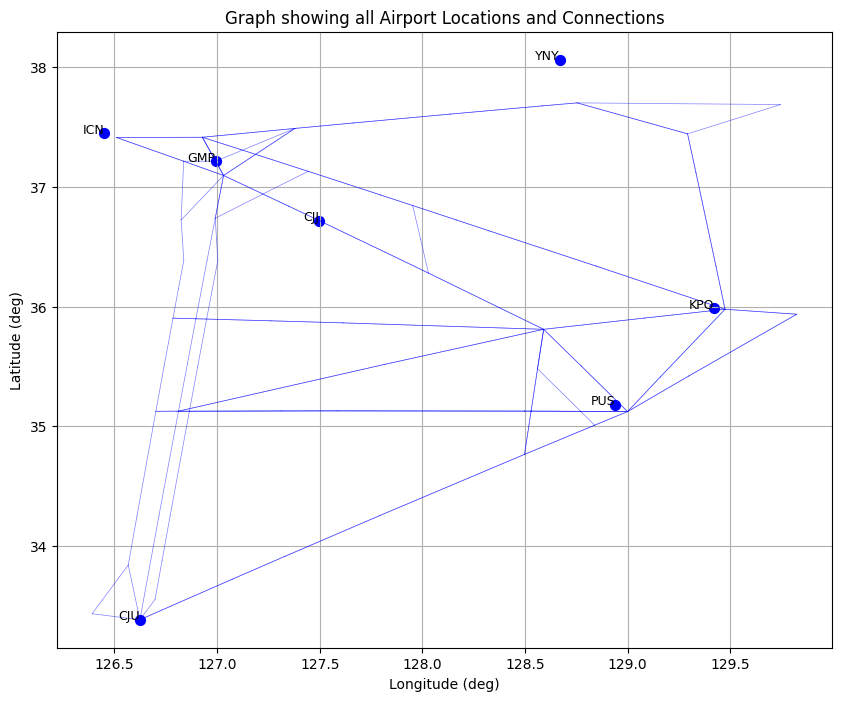

In [21]:
# Visualization
plt.figure(figsize=(10, 8))
# 공항 노드 시각화
for index, row in Korean_airports.iterrows():
    plt.scatter(row['Longitude (deg)'], row['Latitude (deg)'], marker='o', color='blue', s=50)
    plt.text(row['Longitude (deg)'], row['Latitude (deg)'], row['IATA'], fontsize=9, ha='right')

# Visualization the Korean airways
for index, row in Korean_airways.iterrows():
    plt.plot([row['Start Longitude (deg)'], row['End Longitude (deg)']],
             [row['Start Latitude (deg)'], row['End Latitude (deg)']], color='blue',alpha = 0.5, linewidth=0.5)
    
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.title('Graph showing all Airport Locations and Connections')
plt.grid()
plt.show()

### Path construction using A* algorithm under clear weather conditions

In [23]:
import heapq  # Import the heapq module to use the heap queue algorithm (priority queue)

# Define the A* search algorithm function
def a_star(graph, start, goal, heuristic_func):
    open_set = []  # Initialize an empty list to be used as the priority queue
    heapq.heappush(open_set, (0, start))  # Add the start node with a priority of 0 to the open set

    came_from = {}  # Dictionary to store the path or connection between nodes
    g_score = {}  # Dictionary to store the cost from start node to this node
    f_score = {}  # Dictionary to store the estimated total cost from start to goal through this node

    g_score[start] = 0  # Cost from start to start is 0
    f_score[start] = heuristic_func(start, goal)  # Estimate cost from start to goal using heuristic function

    # Continue looping until there are nodes to examine
    while open_set:
        _, current = heapq.heappop(open_set)  # Remove and get the node with the lowest f_score value
        
        # Check if the current node is the goal node
        if current == goal:
            path = []  # Initialize an empty list for the path
            # Retrieve the path from goal to start by tracing back from goal to start
            while current in came_from:
                path.append(current)  # Append the current node to the path
                current = came_from[current]  # Move to the node that led to current
            path.append(start)  # Append the start node to the path
            return path[::-1]  # Return the reversed path from start to goal
        
        # Explore each neighbor of the current node
        for neighbor in graph.edges[current]:
            tentative_g_score = g_score.get(current, 0) + graph.distances[(current, neighbor)]  # Calculate tentative g_score for neighbor
            
            # Update the g_score for the neighbor if the found path is better (lower cost)
            if tentative_g_score < g_score.get(neighbor, float('inf')):
                came_from[neighbor] = current  # Mark current as the parent of neighbor in the optimal path
                g_score[neighbor] = tentative_g_score  # Record the best g_score to this neighbor
                f_score[neighbor] = tentative_g_score + heuristic_func(neighbor, goal)  # Update f_score of neighbor
                heapq.heappush(open_set, (f_score[neighbor], neighbor))  # Add the neighbor to the open set with updated f_score
    
    return None  # Return None if no path is found


In [24]:
# Extract the starting node coordinates based on the IATA code 'CJU' for Jeju International Airport.
start_node = (Korean_airports[Korean_airports['IATA'] == 'CJU']['Longitude (deg)'].values[0],
             Korean_airports[Korean_airports['IATA'] == 'CJU']['Latitude (deg)'].values[0])

# Extract the goal node coordinates based on the IATA code 'GMP' for Gimpo International Airport.
goal_node = (Korean_airports[Korean_airports['IATA'] == 'GMP']['Longitude (deg)'].values[0],
              Korean_airports[Korean_airports['IATA'] == 'GMP']['Latitude (deg)'].values[0])

# Execute the A* algorithm to find the most optimal path from Jeju (CJU) to Gimpo (GMP) using the defined heuristic function.
optimal_path = a_star(graph, start_node, goal_node, heuristic)


#### Total Cost Under Clear Weather Conditions

In [26]:
# Calculate path data
path_data = []  # Initialize an empty list to store path details

# Check if the optimal path is not empty
if optimal_path:
    # Create pairs of nodes representing edges from the optimal path
    path_edges = list(zip(optimal_path[:-1], optimal_path[1:]))
    total_distance = 0  # Initialize a counter for the total distance of the path
    
    # Iterate through each edge in the path
    for edge in path_edges:
        start_pos = edge[0]  # Starting position of the current edge
        end_pos = edge[1]  # Ending position of the current edge
        
        # Calculate the distance between the start and end position using the haversine formula
        distance = haversine(start_pos[0], start_pos[1], end_pos[0], end_pos[1])
        
        # Accumulate the total distance of the path
        total_distance += distance
        
        # Append a dictionary with details of the current segment of the path to the path_data list
        path_data.append({
            'Start': start_pos,
            'End': end_pos,
            'Distance(km)': distance
        })

# Create a DataFrame from the list of dictionaries containing path data
path_df = pd.DataFrame(path_data)

# Display the DataFrame
path_df


,Start,End,Distance(km)
0,"(126.6241, 33.3846)","(126.717, 34.2541)",97.064120
1,"(126.717, 34.2541)","(126.8121, 35.1262)",97.362103
2,"(126.8121, 35.1262)","(126.8554, 35.5212)",44.097318
3,"(126.8554, 35.5212)","(126.8969, 35.8978)",42.043310
4,"(126.8969, 35.8978)","(126.9514, 36.3863)",54.538733
5,"(126.9514, 36.3863)","(126.991, 36.7371)",39.167194
6,"(126.991, 36.7371)","(127.0317, 37.0944)",39.894372
7,"(127.0317, 37.0944)","(126.9932, 37.2136)",13.686561


In [27]:
print("Total distance under clear weather conditions in kilometers is : ",total_distance)

Total distance under clear weather conditions in kilometers is :  427.8537112375015


#### Plot showing optimal path under clear weather conditions

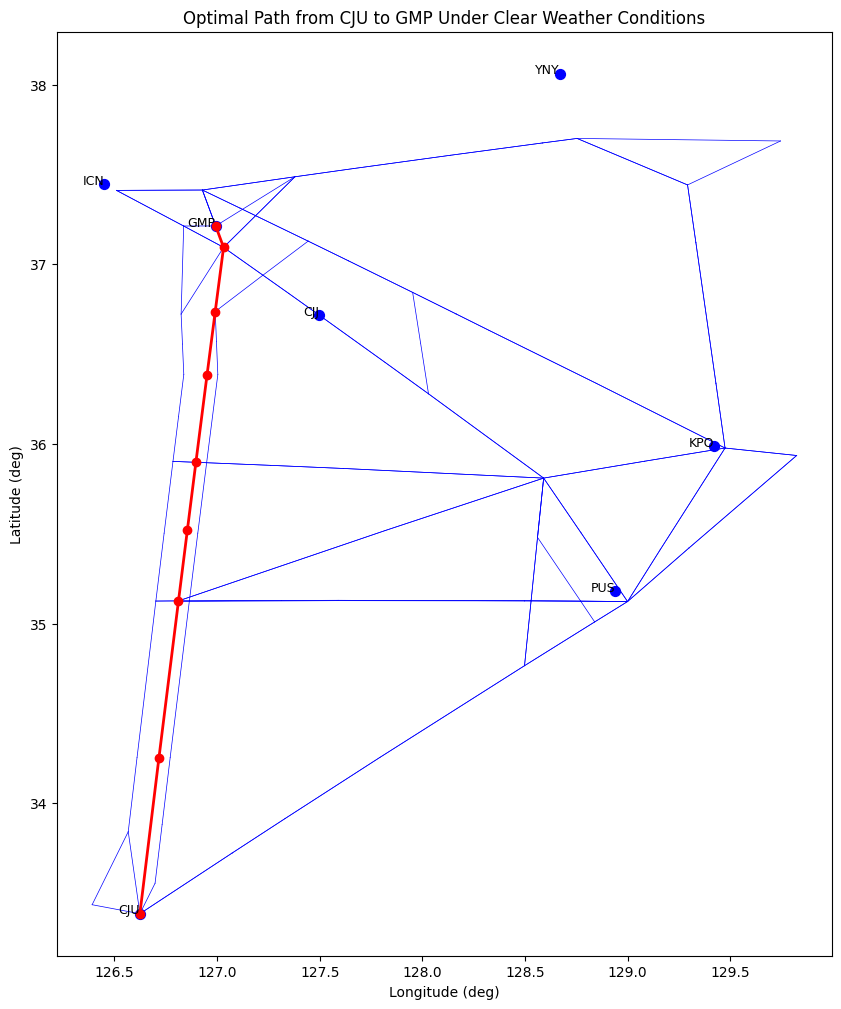

In [29]:
# Visualization
plt.figure(figsize=(10, 12))

# Visualization the Korean airports
for index, row in Korean_airports.iterrows():
    plt.scatter(row['Longitude (deg)'], row['Latitude (deg)'], marker='o', color='blue', s=50)
    plt.text(row['Longitude (deg)'], row['Latitude (deg)'], row['IATA'], fontsize=9, ha='right')

# Visualization the Korean airways
for index, row in Korean_airways.iterrows():
    plt.plot([row['Start Longitude (deg)'], row['End Longitude (deg)']],
             [row['Start Latitude (deg)'], row['End Latitude (deg)']], color='blue', linewidth=0.5)

# Visualization the optimal path
if optimal_path:
    optimal_path_lon = [node[0] for node in optimal_path]
    optimal_path_lat = [node[1] for node in optimal_path]
    plt.plot(optimal_path_lon, optimal_path_lat, color='red', linewidth=2, marker='o')
else:
    print("No optimal path found")

plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.title('Optimal Path from CJU to GMP Under Clear Weather Conditions')
plt.show()


### Path construction using A* algorithm under severe weather conditions

In [31]:
#Import libraries to plot the polygons
from shapely.geometry import Point, Polygon

# Polygons defining prohibited areas
forbidden_polygon = Polygon([(126.4, 34.6), (127.1, 34.6), (127.1, 34.2), (126.4, 34.2)])

# Function to determine if a point is inside a polygon
def is_in_forbidden_area(point):
    return forbidden_polygon.contains(Point(point))

# A* algorithm
import heapq

# implementing A* algorithm with severe weather conditions
def a_star_severe_weather(graph, start, goal, heuristic_func):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}  # Initial cost to reach the start node is 0
    f_score = {start: heuristic_func(start, goal)}  # Estimated total cost from start to goal through y

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()  # Reverse the path to start from the start node
            return path  # Return the path and the cost to reach the goal

        for neighbor in graph.edges[current]:
            if is_in_forbidden_area(neighbor):
                continue  # Skip neighbors that are in forbidden areas

            tentative_g_score = g_score[current] + graph.distances[(current, neighbor)]

            if tentative_g_score < g_score.get(neighbor, float('inf')):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic_func(neighbor, goal)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None  # Return None and infinite cost if no path is found


In [32]:
# Extract the longitude and latitude for the starting node using the IATA code 'CJU' (Jeju International Airport)
start_node = (Korean_airports[Korean_airports['IATA'] == 'CJU']['Longitude (deg)'].values[0],
             Korean_airports[Korean_airports['IATA'] == 'CJU']['Latitude (deg)'].values[0])

# Extract the longitude and latitude for the goal node using the IATA code 'GMP' (Gimpo International Airport)
goal_node = (Korean_airports[Korean_airports['IATA'] == 'GMP']['Longitude (deg)'].values[0],
              Korean_airports[Korean_airports['IATA'] == 'GMP']['Latitude (deg)'].values[0])

# Execute the A* algorithm modified for severe weather conditions, but used here under clear weather conditions
shortest_path_severe_weather = a_star_severe_weather(graph, start_node, goal_node, heuristic)


#### Total Cost Under Severe Weather Conditions

In [34]:
# Initialize an empty list to hold data about each segment of the path.
path_data = []

# Check if the A* algorithm has returned a path.
if shortest_path_severe_weather :
    # Create a list of edges by pairing sequential nodes to represent the path as a sequence of segments.
    path_edges = list(zip(shortest_path_severe_weather [:-1], shortest_path_severe_weather[1:]))
    total_distance_severe_weather = 0  # Initialize a counter to sum up the total distance of the path.

    # Iterate over each edge in the path to calculate distances.
    for edge in path_edges:
        start_pos = edge[0]  # Extract the start position (longitude, latitude) of the edge.
        end_pos = edge[1]  # Extract the end position (longitude, latitude) of the edge.
        
        # Calculate the distance between the start and end positions using the haversine formula.
        distance = haversine(start_pos[0], start_pos[1], end_pos[0], end_pos[1])
        
        # Add the distance of the current edge to the total distance of the path.
        total_distance_severe_weather += distance
        
        # Append a dictionary with details of the current segment to the path_data list.
        path_data.append({
            'Start': start_pos,
            'End': end_pos,
            'Distance(km)': distance
        })

# Convert the list of dictionaries into a DataFrame for easy viewing and analysis.
path_df_severe_weather = pd.DataFrame(path_data)

# Display the DataFrame containing the path details.
path_df_severe_weather


,Start,End,Distance(km)
0,"(126.6241, 33.3846)","(127.0731, 33.7222)",56.038930
1,"(127.0731, 33.7222)","(127.3314, 33.9145)",32.040958
2,"(127.3314, 33.9145)","(127.7929, 34.2547)",56.897307
3,"(127.7929, 34.2547)","(128.4977, 34.7654)",85.995189
4,"(128.4977, 34.7654)","(128.5297, 35.1267)",40.280461
5,"(128.5297, 35.1267)","(128.561, 35.4797)",39.354443
6,"(128.561, 35.4797)","(128.5908, 35.8098)",36.804086
7,"(128.5908, 35.8098)","(128.03, 36.2791)",72.562470
8,"(128.03, 36.2791)","(127.8192, 36.4534)",27.053494
9,"(127.8192, 36.4534)","(127.5009, 36.7144)",40.619942


In [35]:
print("Total distance under severe weather conditions in kilometers is : ",total_distance_severe_weather)

Total distance under severe weather conditions in kilometers is :  560.7129912383314


#### Plot showing optimal path under severe weather conditions

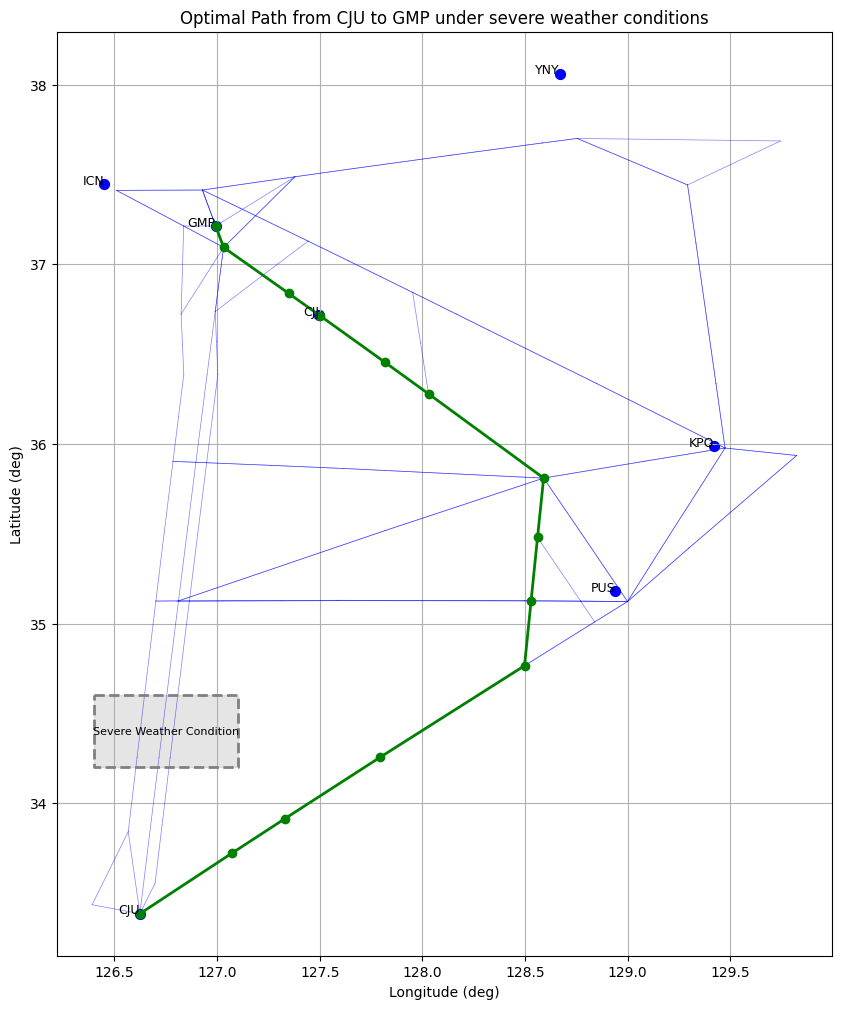

In [37]:
# Visualization
plt.figure(figsize=(10, 12))

# Visualization the Korean airports
for index, row in Korean_airports.iterrows():
    plt.scatter(row['Longitude (deg)'], row['Latitude (deg)'], marker='o', color='blue', s=50)
    plt.text(row['Longitude (deg)'], row['Latitude (deg)'], row['IATA'], fontsize=9, ha='right')

# Visualization the Korean airways
for index, row in Korean_airways.iterrows():
    plt.plot([row['Start Longitude (deg)'], row['End Longitude (deg)']],
             [row['Start Latitude (deg)'], row['End Latitude (deg)']], color='blue',alpha = 0.5, linewidth=0.5)

# Visualize forbidden zones polygon
x, y = forbidden_polygon.exterior.xy
plt.plot(x, y, color='grey', linestyle='--', linewidth=2)
plt.fill(x, y, color='grey', alpha=0.2)
centroid = forbidden_polygon.centroid
plt.text(centroid.x, centroid.y, 'Severe Weather Condition', color='black', fontsize=8,
         ha='center', va='center')

# Visualize the optimal route
optimal_lon = [node[0] for node in shortest_path_severe_weather]
optimal_lat = [node[1] for node in shortest_path_severe_weather]
plt.plot(optimal_lon, optimal_lat, color='green', linewidth=2, marker='o')


plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.title('Optimal Path from CJU to GMP under severe weather conditions')
plt.grid()
plt.show()

#### Checking if shortest path identified by our algorithm represents a global optimum

In [39]:
# Define the function is_admissible with parameters heuristic, graph, and goal
def is_admissible(heuristic, graph, goal):
    # Iterate through each node in the graph's node list
    for node in graph.nodes:
        # Retrieve the actual distance from the node to the goal if it exists, otherwise set it to infinity
        actual_distance = graph.distances[(node, goal)] if (node, goal) in graph.distances else float('inf')
        # Compare the heuristic estimate from the node to the goal with the actual distance
        if heuristic(node, goal) > actual_distance:
            # If the heuristic estimate is greater than the actual distance, return False
            return False
    # If the heuristic is never greater than the actual distances for all nodes, return True
    return True


In [40]:
print('Is admissibility property satisfied ? ',is_admissible(heuristic,graph,goal_node))

Is admissibility property satisfied ?  True


In [41]:
# Define the function is_consistent with parameters heuristic, graph, and goal
def is_consistent(heuristic, graph, goal):
    # Iterate through each node in the graph's node list
    for node in graph.nodes:
        # Check if the current node has any outgoing edges
        if node in graph.edges:
            # Iterate through each neighbor connected to the current node
            for neighbor in graph.edges[node]:
                # Calculate the actual distance between the node and its neighbor
                actual_distance = graph.distances[(node, neighbor)]
                # Check if the absolute difference between the heuristic estimates for the node and its neighbor exceeds the actual distance
                if abs(heuristic(node, goal) - heuristic(neighbor, goal)) > actual_distance:
                    # If the absolute difference is greater than the actual distance, return False
                    return False
    # If the heuristic differences do not exceed the actual distances for all node pairs, return True
    return True


In [42]:
print('Is consistency property satisfied ? ',is_consistent(heuristic,graph,goal_node))

Is consistency property satisfied ?  True


In [43]:
# Define the function is_complete with parameter graph
def is_complete(graph):
    # Check if all edges have non-negative weights
    for (from_node, to_node), distance in graph.distances.items():
        # Check if the distance (weight) of the edge is negative
        if distance < 0:
            # If any edge has a negative weight, return False
            return False
    # If all edges have non-negative weights, return True
    return True


In [44]:
print('Is completeness property satisfied ? ',is_complete(graph))

Is completeness property satisfied ?  True


#### References

- https://choiseokwon.tistory.com/210

- https://velog.io/@1ncursio/A-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98%EC%9D%84-%EA%B5%AC%ED%98%84%ED%95%B4%EB%B3%B4%EC%9E%90-Python3


- https://www.geeksforgeeks.org/a-search-algorithm-in-python/

- chatGPT